# <font color="blue">Filipe Borba e Vitória Mattos</font>

# Filtro de partículas


Cada partícula vai ser representada por uma lista [x,y,theta]

Trabalhe com 2 listas:

	S = []  # Vai conter as n partículas. 

	W = [] # Pesos das partículas

	n_part = # Número de partículas


# Atividades


1. Crie uma função que gere n partículas aleatórias distribuidas uniformemente dentro de uma área minx, miny, maxx, maxy (passados como parâmetros). Veja a funcao 

	Devolve uma lista com n partículas

2. Descubra como desenhar as n partículas (analise o módulo inspercles)

3. Faça o desenho das partículas

4. Crie uma lista para simular os movimentos do robô. Veja a lista chamada <code>movimentos</code> que é usada na seção *Teste de animação*, mais abaixo

5. Crie uma função que aplica um deslocamento [delta_x, delta_y, delta_theta] com um desvio padrão [std_x, std_y, std_theta] a todas as partículas

6. Desenhe as partículas após o deslocamento

7. Descubra como calcular $P(D|H)$ analisando o Python Notebook. A função que traça os raios está no modulo inspercles

Programe a aplicação da equação que está na pág. 853 do livro do Norvig $$P(z_t | x_t) = \alpha \prod_{j}^M{e^{\frac{-(z_j - \hat{z_j})}{2\sigma^2}}}$$

Ou seja, para cada raio estimado $\hat{z_j}$ e leitura real $z_j$ calcule a probabilidade daquele raio ter acontecido dado que a posição do robô fosse de fato a da partícula


8 . Usando os resultados de 7 calcule $P(H|D)$ e insira numa lista de probabilidades das partículas

9 . Reamostre as partículas de forma proporcional à probabilidade



In [1]:
from random import randint, choice
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import math
import random
from pf import Particle
from nav_msgs.msg import OccupancyGrid
from occupancy_field import OccupancyField
from helper_functions import angle_normalize, angle_diff

import cv2

import sys
import os
os.getcwd() 
import sys
sys.path.append(os.getcwd())


import inspercles
reload(inspercles)


# Para suprimir alguns warnings do Matplotlib Inline
import warnings
warnings.simplefilter('ignore')
%matplotlib inline


## Diretõrio de trabalho

In [2]:
!pwd




/home/borg/catkin_ws/src/robot17/particle_filter/jupyter_particle


In [3]:
# Dados do arquivo mapa.yaml

resolution = 0.020000
origin =  [-5.000000, -5.000000, 0.000000]
occupied_thresh = 0.8
free_thresh =  0.2

inspercles.free_thresh = free_thresh # Limiar em tons de cinza para que uma celula seja considerada livre
inspercles.occupied_thresh = occupied_thresh # Limiar de celula ocupada
inspercles.origin = origin
inspercles.resolution = resolution


In [4]:


from PIL import Image as PilImage


color_image = cv2.imread("sparse_obstacles.png")
pil_image = color_image
np_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)


#color_image = PilImage.open("sparse_obstacles.png", 'r')
#pil_image = color_image.convert('1') # Converte a imagem PIL para Grayscale
#np_image = np.asarray(pil_image)

particle_size = 10

#import matplotlib_render as plotmap


back_color = "black"
colors     = ['red', 'green', 'cyan', 'yellow']
width, height = 775, 746

inspercles.width = width
inspercles.height = height




initial_pose = [200, 200, math.pi/8] # Posicao inicial considerada para o pf
inspercles.initial_pose = initial_pose
pose = [330, 220, math.radians(90)] # posicao "verdadeira" do robo 
inspercles.pose = pose
robot_radius=10   # Raio do robo
inspercles.robot_radius = robot_radius


# Os angulos em que o robo simulado vai ter sensores
angles = np.linspace(0.0, 2*math.pi, num=8)

particle_cloud = []



    
    
    
    

## Mapa com posição inicial

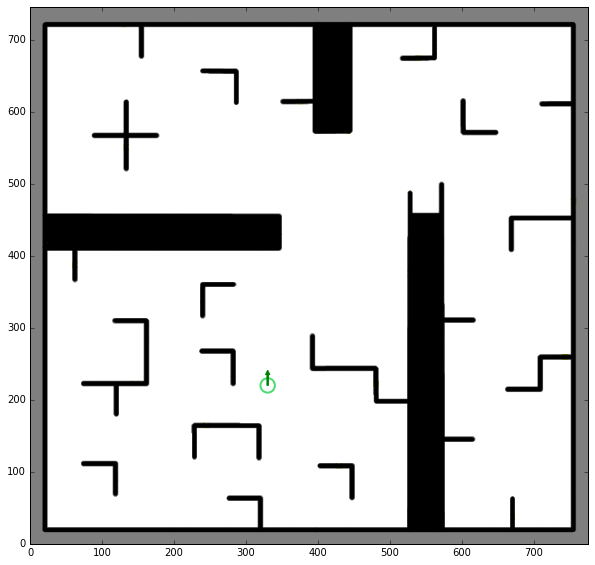

In [5]:
inspercles.nb_draw_map(color_image, pose=pose, robot=True)

A função *nb_initialize_particle_cloud()* pertence ao módulo <code>inspercles</code> e já faz uma primeira aleatorização das partículas

In [6]:
# Inicializa as particulas
particulas = inspercles.nb_initialize_particle_cloud()

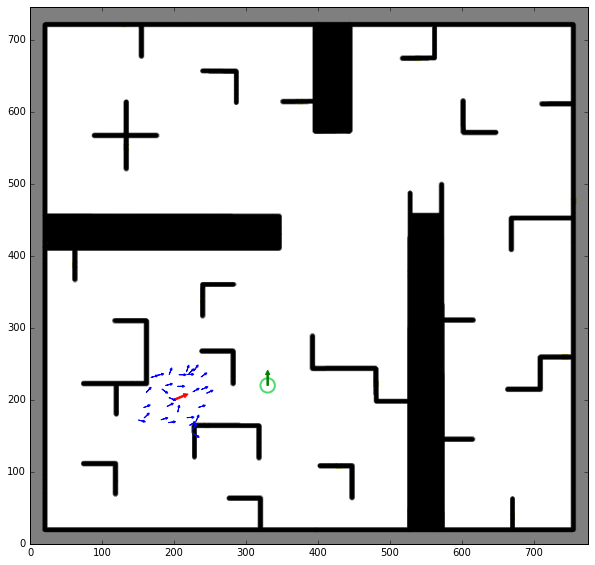

In [7]:
inspercles.nb_draw_map(color_image, particles = particulas, initial_position = initial_pose, pose=pose, robot=True)

In [8]:
angles

array([ 0.        ,  0.8975979 ,  1.7951958 ,  2.6927937 ,  3.5903916 ,
        4.48798951,  5.38558741,  6.28318531])

# Simulação da imagem do laser

Para simular a leitura **real** do robo, use *nb_simulate_lidar* passando a posição real do robô, os ângulos do sensor e a np_image com o mapa

In [9]:
leituras, lidar_map = inspercles.nb_simulate_lidar_fast(pose, angles, np_image)


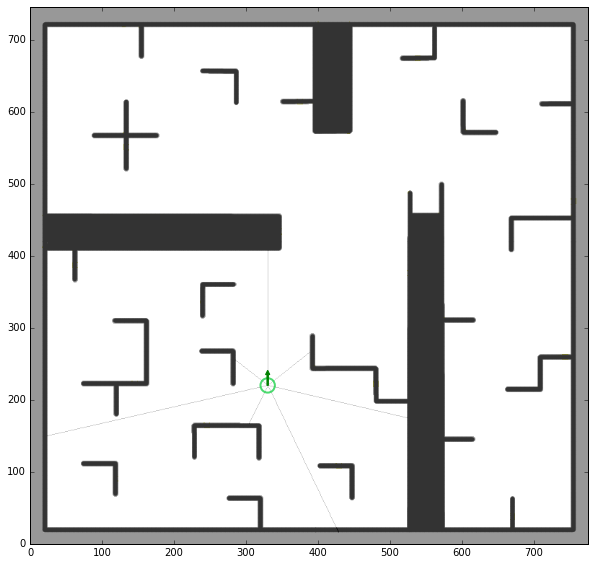

In [10]:
ax = inspercles.nb_draw_map(lidar_map, robot=True, pose=pose)
ax.imshow(color_image, alpha=0.8)
#nb_draw_map(occupancy_image)

As leituras serao retornadas pela simulacao do lidar. Sao armazenadas na forma de um dicionario com angulo: valor da leitura

In [11]:
# As predicoes teoricas das leituras
leituras

{0.0: 187.0,
 0.89759790102565518: 57.557160346046977,
 1.7951958020513104: 313.86936016140152,
 2.6927937030769655: 58.825562001261339,
 3.5903916041026207: 226.42291789164747,
 4.4879895051282759: 197.96335461160291,
 5.3855874061539311: 74.184784446016039,
 6.2831853071795862: 187.0}

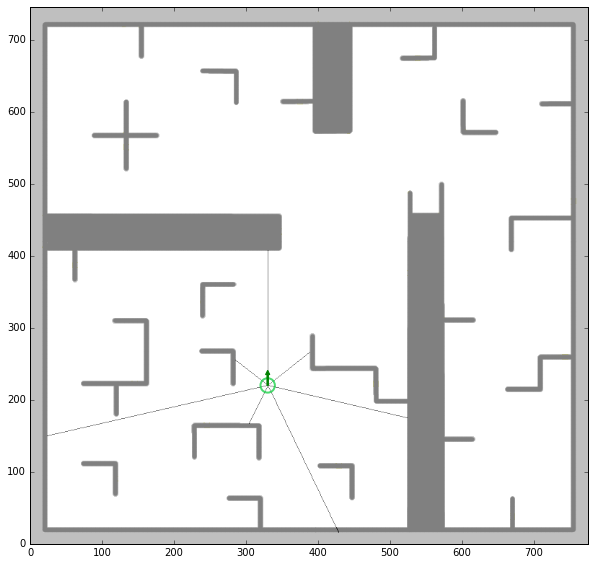

In [12]:
ax = inspercles.nb_draw_map(lidar_map, pose=pose, robot=True)
#ax.imshow(occupancy_image, alpha=0.2)
ax.imshow(pil_image, alpha=0.5)

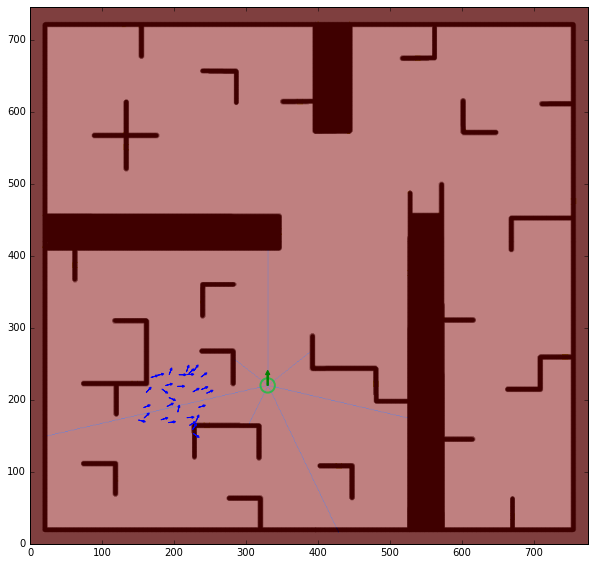

In [13]:
ax = inspercles.nb_draw_map(pil_image, pose=pose, robot=True, particles=particulas)
#ax.imshow(occupancy_image, alpha=0.2)
ax.imshow(lidar_map, alpha=0.5)

## Gerando uma animação

In [14]:
# Coloque nesta lista os deslocamentos do robo

movimentos = [[-10, -10, 0], [-10, 10, 0], [-10,0,0], [-10, 0, 0],
              [0,0,math.pi/12.0], [0, 0, math.pi/12.0], [0, 0, math.pi/12],[0,0,-math.pi/4],
              [-5, 0, 0],[-5,0,0], [-5,0,0], [-10,0,0],[-10,0,0], [-10,0,0],[-10,0,0],[-10,0,0],[-15,0,0],
              [0,0,-math.pi/4],[0, 10, 0], [0,10,0], [0, 10, 0], [0,10,0], [0,0,math.pi/8], [0,10,0], [0,10,0], 
              [0,10,0], [0,10,0], [0,10,0],[0,10,0],
              [0,0,-math.radians(90)],
              [math.cos(math.pi/3)*10, math.sin(math.pi/3),0],[math.cos(math.pi/3)*10, math.sin(math.pi/3),0],[math.cos(math.pi/3)*10, math.sin(math.pi/3),0],
              [math.cos(math.pi/3)*10, math.sin(math.pi/3),0]
             ]


Para gerar os gifs é preciso ter o pacote *imagemagick*

O imagemagick pode ser obtido com o seguinte comando:
    sudo apt-get install imagemagick 
    
Agora vamos invocar na linha de comando o seguinte comando:
    convert -delay 10 -loop 1 anim*png animated.gif
    
Este comando criou um arquivo chamado *animated.fig*, que leremos abaixo:
    

Infelizmente o IPython Notebook 2 nao parece exibir animacoes em Gif por default, mas voce pode abrir o arquivo no diretorio de trabalho e devera'  ve-lo.

<img src="animated.gif">

# Começando a Atividade

In [36]:
def criar_particulas(n, minx, miny, maxx, maxy):
    particle_cloud = []
    for i in range(n):
        x = random.uniform(minx, maxx)
        y = random.uniform(miny, maxy)
        theta = random.uniform(math.radians(0), math.radians(360))
        p = Particle(x, y, theta, w=1.0) # A prob. w vai ser normalizada depois
        particle_cloud.append(p)
    return particle_cloud

In [37]:
#Desenhando as partículas
def desenhar_setas(x, y, theta, ax, l = 15, color='y', headwidth=3.0, headlength=3, width=0.001):
    #Desenha uma seta na posição x, y com um ângulo theta
    #ax é o contexto gráfico
    deltax = l*math.cos(theta)
    deltay = l*math.sin(theta)
    ax.arrow(x, y, deltax, deltay, head_width=headwidth, head_length=headlength, fc=color,  ec=color, width=width)

def desenhar_particulas(particles, ax):
    #particles - uma lista de objetos Particle
    #ax - eixo
    #particle_size iniciado bem acima = 10
    for p in particles:
        desenhar_setas(p.x, p.y, p.theta, ax, particle_size, color='b')

In [38]:
#Iniciar as partículas para que o desenho ocorra
def iniciar_particulas(xy_theta=None):
    #xy_theta: a triple consisting of the mean x, y, and theta (yaw) to initialize the
    #particle cloud around.
    if xy_theta == None:
        #xy_theta = convert_pose_to_xy_and_theta(.odom_pose.pose)
        pass
    # TODO create particles
    particle_cloud = criar_particulas(100,200,100,400,300)
        
    inspercles.normalize_particles(particle_cloud)
    inspercles.update_robot_pose(particle_cloud, np.ones(len(particle_cloud)))    
    return particle_cloud

In [39]:
initial_pose = [200, 200, math.pi/8] # Posicao inicial considerada para o
pose = [320, 200, math.radians(90)] # posicao "verdadeira" do robo 

def desenhar_posicao_inicial(pose_xytheta, ax):
    x = pose_xytheta[0]
    y = pose_xytheta[1]
    theta = pose_xytheta[2]
    l = 15
    desenhar_setas(x, y, theta, ax, l=l, color='r', width=2, headwidth=6, headlength=6)

In [40]:
def desenhar_robo(position, ax, radius=10):
    from matplotlib.patches import Circle
    circle = Circle((position[0], position[1]), radius, facecolor='none',
                    edgecolor=(0.0, 0.8, 0.2), linewidth=2, alpha=0.7)
    ax.add_patch(circle)

In [41]:
#Para iniciar o mapa
def desenhar_mapa(mapa_numpy, particles = None, initial_position=False, pose=False, robot=False):
    """
        particles - um conjunto de partículas definidas como objetos do tipo partícula

        initial_position - cor para desenhar a posição inicial do robo

        pose - pose do robo

        robot - booleano que determina se o robô é desenhado como um círculo ou não
    """
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set(xlim=[0, width], ylim=[0, height]) # Or use "ax.axis([x0,x1,y0,y1])"

    fig.canvas.draw()

    #def update():

    plt.imshow(mapa_numpy, cmap='Greys_r')
    if initial_position:
        desenhar_posicao_inicial(initial_pose,ax)
    if particles:
        desenhar_particulas(particles, ax)
    if pose:
        desenhar_setas(pose[0], pose[1], pose[2], ax, color='g', width=2, headwidth=6, headlength=6)
    if robot:
        desenhar_robo(pose, ax, radius=robot_radius)

    return ax # Retornamos o contexto grafico caso queiram fazer algo depois

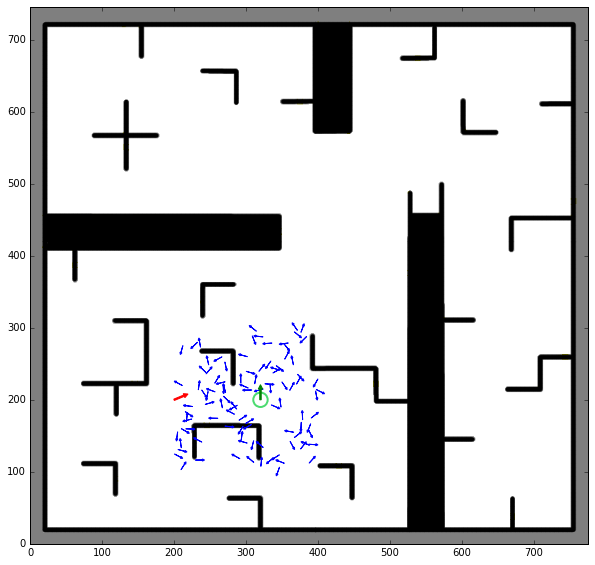

In [42]:
# Inicializa as particulas e o robô

novas_particulas = iniciar_particulas()
desenhar_mapa(color_image, particles = novas_particulas, initial_position=initial_pose, pose=pose, robot=True)

### Movimentando o robô

In [43]:
# Coloque nesta lista os deslocamentos do robo

movimentos = [[-10, -10, 0], [-10, 10, 0], [-10,0,0], [-10, 0, 0],
              [0,0,math.pi/12.0], [0, 0, math.pi/12.0], [0, 0, math.pi/12],[0,0,-math.pi/4],
              [-5, 0, 0],[-5,0,0], [-5,0,0], [-10,0,0],[-10,0,0], [-10,0,0],[-10,0,0],[-10,0,0],[-15,0,0],
              [0,0,-math.pi/4],[0, 10, 0], [0,10,0], [0, 10, 0], [0,10,0], [0,0,math.pi/8], [0,10,0], [0,10,0], 
              [0,10,0], [0,10,0], [0,10,0],[0,10,0],
              [0,0,-math.radians(90)],
              [math.cos(math.pi/3)*10, math.sin(math.pi/3),0],[math.cos(math.pi/3)*10, math.sin(math.pi/3),0],[math.cos(math.pi/3)*10, math.sin(math.pi/3),0],
              [math.cos(math.pi/3)*10, math.sin(math.pi/3),0]
             ]

In [44]:
# #Crie uma função que aplica um deslocamento [delta_x, delta_y, delta_theta]
# #com um desvio padrão [std_x, std_y, std_theta] a todas as partículas
# global pesos_particulas

# pesos_particulas = []


# def deslocamento(novas_particulas, delta, pose):
#     global pesos_particulas
#     #Desloca a posição da partícula
#     delta_x = delta[0]
#     delta_y = delta[1]
#     delta_theta = delta[2]
    
#     for p in novas_particulas:
#         Ex = random.gauss(0, 2)
#         Ey = random.gauss(0, 2)
#         Etheta = random.gauss(0, 5)
#         p.x = p.x + delta_x + Ex
#         p.y = p.y + delta_y + Ey
#         p.theta = p.theta + delta_theta + Etheta
        
#     pose[0] += delta_x
#     pose[1] += delta_y
#     pose[2] += delta_theta
    
#     lista_produto = []
    
#     for particula in novas_particulas:
#         zjchapeu = inspercles.nb_simulate_lidar_fast([particula.x, particula.y, particula.theta], angles, np_image)[0]
#         produto = 1
#         for i in angles:
#             P = math.e**(-(i-zjchapeu.values()[0]) /((2*5)**2) )
#             produto = produto * P
#         lista_produto.append(produto)
    
#     soma_lista_produto = sum(lista_produto)
#     alpha = 1/soma_lista_produto
    
#     pesos_particulas = []
    
#     for i in range(len(lista_produto)):
#          pesos_particulas.append(lista_produto[i]*alpha)
            

# #zi = leituras
# #zjchapeu é novas_particulas
# #desvio padrao de 5cm
# #tem que fazer um 'for' com norm.pdf(zj (aquele das leituras), loc=zjchapeu(cada particula), scale=5cm)

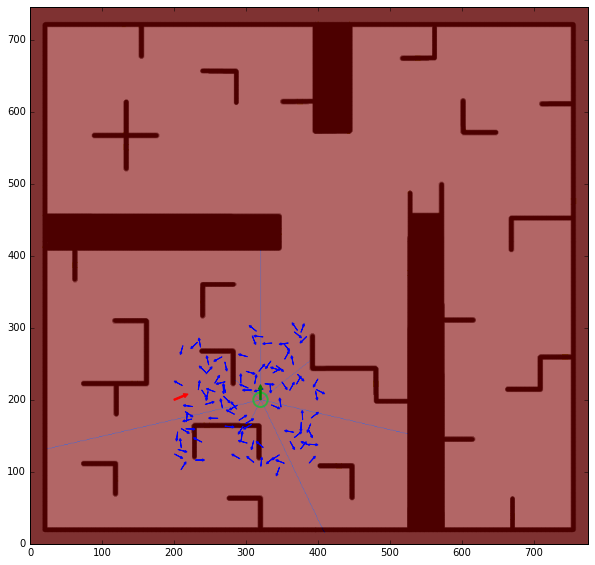

In [45]:
leituras, lidar_map = inspercles.nb_simulate_lidar_fast(pose, angles, np_image)
mapa = desenhar_mapa(color_image, particles = novas_particulas, initial_position=initial_pose, pose=pose, robot=True)
mapa.imshow(lidar_map, alpha=0.6)

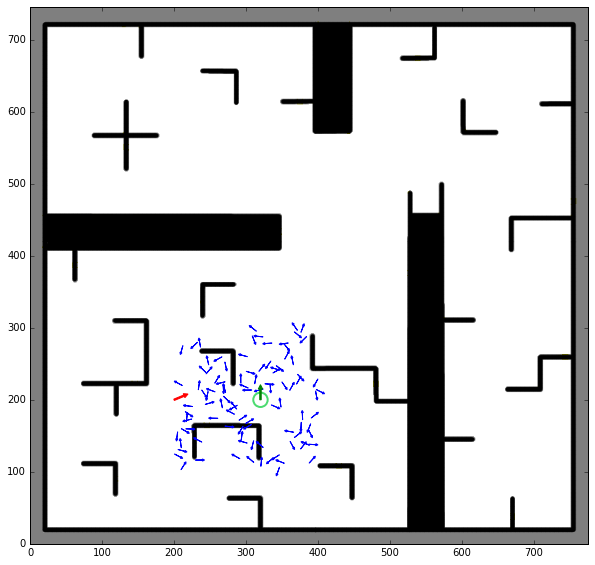

In [46]:
#Desenhe as partículas após o deslocamento
# Inicializa as particulas
desenhar_mapa(color_image, particles = novas_particulas, initial_position=initial_pose, pose=pose, robot=True)

In [47]:
# particulas_reamostradas = Particle.draw_random_sample(novas_particulas, pesos_particulas, 50)

# for n_p in particulas_reamostradas:
#     n_p.w = 1.0

In [ ]:
plt.ioff() # Desliga o modo interativo, para nao aparecerem muitas imagens no meio

frames = 1

for delta in movimentos:
    #Desloca as partículas
    delta_x = delta[0]
    delta_y = delta[1]
    delta_theta = delta[2]
    
    for p in novas_particulas:
        Ex = random.gauss(0, 2)
        Ey = random.gauss(0, 2)
        Etheta = random.gauss(0, 5)
        p.x = p.x + delta_x + Ex
        p.y = p.y + delta_y + Ey
        p.theta = p.theta + delta_theta + Etheta
        retorno_lidar_robo = np.copy(lidar_map)
        retorno_lidar_particulas = np.copy(lidar_map)
        
    pose[0] += delta_x
    pose[1] += delta_y
    pose[2] += delta_theta
    
    #Deslocamento feito, agora calcula a probabilidade
    
    lista_produto = []
    
    zjreal, lidar_map = inspercles.nb_simulate_lidar_fast(pose, angles, np_image)
    
    for p in novas_particulas:
        zjchapeu = inspercles.nb_simulate_lidar_fast([p.x, p.y, p.theta], angles, np_image)[0]
        for i in range(8):
            #Range 8 porque são 8 leituras
            P = math.e**(-(zjreal.values()[i]-zjchapeu.values()[i] / ((2*5)**2)))
            produto = 1
            produto = produto * P
        lista_produto.append(produto)
    
    soma_lista_produto = sum(lista_produto)
    alpha = 1/soma_lista_produto
    
    pesos_particulas = []
    
    for i in range(len(lista_produto)):
         pesos_particulas.append(lista_produto[i]*alpha)

    particulas_reamostradas = Particle.draw_random_sample(novas_particulas, pesos_particulas, 100)
    novas_particulas = particulas_reamostradas

    # Desenha as particulas
    mapa = desenhar_mapa(color_image, particles = novas_particulas, initial_position=initial_pose, pose=pose, robot=True)
    #ax.imshow(occupancy_image, alph.2)
    # Desenha o mapa do lidar
    
    mapa.imshow(lidar_map, alpha=0.5)

    plt.savefig("borbaevitoria%04d.png"%frames, bounds="tight")
    
    frames+=1
    plt.close('all')


plt.ion()

In [ ]:
!convert -delay 10 -loop 1 borbaevitoria*png borbaevitoria.gif